In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add local scripts to path
import os,sys
sys.path.insert(0,os.path.abspath("./"))
import neurotools

# Set up cache
from neurotools.jobs.initialize_system_cache import initialize_caches,cache_test
PYCACHEDIR = os.path.abspath('./')
CACHENAME  = 'PPC_cache'
from neurotools.tools import ensure_dir
ensure_dir(PYCACHEDIR+os.sep+CACHENAME)
initialize_caches(
    level1  = PYCACHEDIR,
    force   = False,
    verbose = False,
    CACHE_IDENTIFIER = CACHENAME)

# Import libraries
from neurotools.nlab import *
import ppc_data_loader

# Set this to the location of the PPC data on your machine
ppc_data_loader.path = '/home/mer49/Dropbox (Cambridge University)/Datasets/PPC_data/'
from ppc_data_loader   import *
from ppc_trial         import *

# Numpy configuration
from scipy.stats import norm
np.seterr(all='ignore')
np.set_printoptions(precision=3)
import warnings
warnings.filterwarnings("ignore","scipy")
print('Numpy configured')

# Matplotlib configuration
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
TEXTWIDTH = 5.62708
matplotlib.rcParams['figure.figsize'] = (TEXTWIDTH, TEXTWIDTH/sqrt(2))
import warnings
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings("ignore",category=MatplotlibDeprecationWarning)
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 9
matplotlib.rc('font' , size   =SMALL_SIZE ) # controls default text sizes
matplotlib.rc('axes' , titlesize=MEDIUM_SIZE) # fontsize of the axes title
matplotlib.rc('axes' , labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
matplotlib.rc('xtick' , labelsize=SMALL_SIZE ) # fontsize of the tick labels
matplotlib.rc('ytick' , labelsize=SMALL_SIZE ) # fontsize of the tick labels
matplotlib.rc('legend', fontsize =SMALL_SIZE ) # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title
matplotlib.rc('lines' , solid_capstyle='round')
plt.rcParams['image.cmap'] = 'parula'
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=[BLACK,RUST,TURQUOISE,OCHRE,AZURE,MAUVE,MOSS,INDEGO,VIOLET,VERIDIAN,CRIMSON])
matplotlib.rc('savefig',dpi=240)
print('Matplotlib configured')

Data location is /home/mer49/Workspace2/PPC_data/
Numpy configured
Matplotlib configured


## Generate plot 3D

## Load prepared data

In [2]:
from itertools import product
from collections import defaultdict

animals  = get_subject_ids()
animal   = choice(animals)
sessions = get_session_ids(animal)
print(sessions)
si1      = choice(range(len(sessions)-1))
s1,s2    = sessions[si1:si1+2]

use = [(1,[1, 4, 5, 6, 7, 10, 14]),
    (3,[ 1,  2,  4,  6,  7,  8,  9, 10, 11, 12]),
    (4,[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
    (5,[6, 7, 8, 9, 10, 11, 12])]

NXVAL = 10

# Load e.g. data

sdr = './datafiles/concatenated_analyses_processed_extracted_features/'
vnm = 'Y_position'
pfx = 'concatenated_analyses_data_'
fnt = sdr+pfx+'M%d_sessions_%s_days_%s_variable_%s'

animal,sessions = use[2]
ss = '_'.join(map(str,sessions))
dm = dict(zip(get_session_ids(animal),get_days(animal)))
dy = array([dm[s] for s in sessions])
dd = '_'.join(map(str,dy))
fn = fnt%(animal,ss,dd,vnm)
data = loadmat(fn)
x = amap(squeeze,data['X'].squeeze())
y = amap(squeeze,data['Y'].squeeze())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 25]


## Approach

The previous approach simply concatenated, then trained. It used 1/D of the average amount of data per day, where D is the total number of days, to build the dataset used for training and testing. It trained using the `reglstsq` with default regularization strength. It manually calculated the testing error as mean-absolute error after the fact.

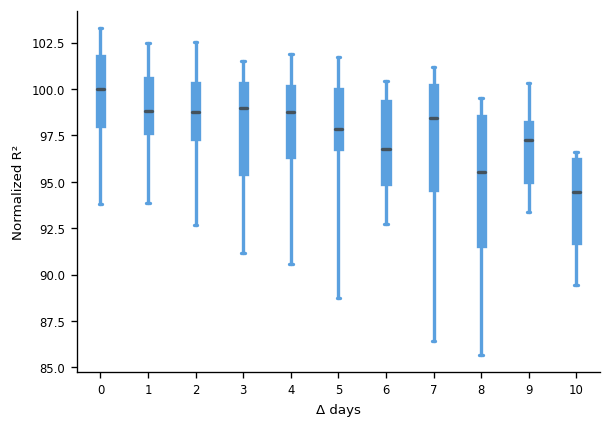

In [3]:
def get_concatenated_R2(x,y,M):
    # Thin the data to M trials in total
    x,y   = cat(x),cat(y)
    ntr   = len(y)
    usetr = choice(arange(ntr),M,replace=False)
    x     = x[usetr]
    y     = y[usetr]
    block = partition_trials_for_crossvalidation(y,NXVAL,shuffle=True)
    r2    = []
    for i in range(NXVAL):
        # Train
        itr = cat(block[:i]+block[i+1:])
        wc  = reglstsq(cat(x[itr]),cat(y[itr]))
        # Test
        its = block[i]
        xts = cat(x[its])
        yts = cat(y[its])
        r2 += [1-mean(abs(yts-xts@wc)**2)/var(yts)]
    return r2

from collections import defaultdict
res   = defaultdict(list)
M     = min(map(len,x))
nsess = len(sessions)
for s1 in range(nsess):
    for s2 in range(s1+1,nsess):
        res[dy[s2-1]-dy[s1]] += get_concatenated_R2(x[s1:s2],y[s1:s2],M)

normto = median(res[0])
maxdd = max(res.keys())
for dd in range(0,maxdd+1):
    r2 = res[dd]/normto*100
    colored_boxplot(r2,[dd],AZURE)
xlabel('Δ days')
ylabel('Normalized R²')
simpleaxis()

## Now plot


In [4]:
@memoize
def get_concat_normalized_r2(animal,sessions,NXVAL=10,nsamples=50):
    # Get data
    ss = '_'.join(map(str,sessions))
    dm = dict(zip(get_session_ids(animal),get_days(animal)))
    dy = array([dm[s] for s in sessions])
    dd = '_'.join(map(str,dy))
    fn = fnt%(animal,ss,dd,vnm)
    data = loadmat(fn)
    x = amap(squeeze,data['X'].squeeze())
    y = amap(squeeze,data['Y'].squeeze())
    
    # Evaluate concatenated on a range of days
    res   = defaultdict(list)
    M     = min(map(len,x))
    nsess = len(sessions)
    for isample in range(nsamples):
        for s1 in range(nsess):
            for s2 in range(s1+1,nsess):
                res[dy[s2-1]-dy[s1]] += [mean(get_concatenated_R2(x[s1:s2],y[s1:s2],M))]
            
    # Normalize
    normto = median(res[0])
    for k in res.keys():
        res[k] = res[k]/normto*100
    return res

In [5]:
# cache data-based results
[get_concat_normalized_r2(*u,nsamples=20) for u in use];

In [6]:
# Load DVR's results
fn = './datafiles/DVRF3D-1/forward_position.mat'
import h5py
f = h5py.File(fn,'r')
print('Contains:')
from neurotools.hdfmat import *
printmatHDF5(f)
ss = getHDF(f,'R2_stds')
mu = getHDF(f,'R2_vecs')

Contains:
  | R2_95pc_Conf | 4       | object | 'numpy.ndarray | 
  | R2_stds      | 4       | object | 'numpy.ndarray | 
  | R2_vecs      | 4       | object | 'numpy.ndarray | 
  | readme       | 184 x 1 | uint16 | 'numpy.ndarray | 


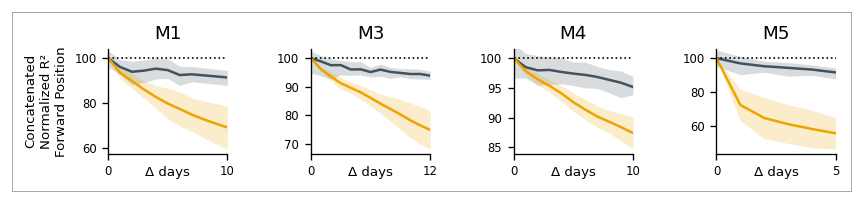

In [7]:
TEXTWIDTH = 7
figure(figsize=(TEXTWIDTH,1.5))

save_for_later = {}

for i,(animal, sessions) in enumerate(use):
    subplot(1,4,i+1)
    res = get_concat_normalized_r2(animal, sessions)
    dd  = sorted(list(res.keys()))
    r2  = [res[d] for d in dd]
    md  = amap(median,r2)
    
    sns = '_'.join(map(str,sessions))
    save_for_later['m%d_sessions_%s'%(animal,sns)] = {
        'delta_days':dd,
        'median_normalized_R2':md
    }
    
    p5  = [percentile(r,5 ) for r in r2]
    p95 = [percentile(r,95) for r in r2]
    fill_between(dd,p5,p95,color=BLACK,alpha=0.2,lw=0)
    plot(dd,md,color=BLACK)
    xlabel('Δ days')
    if i==0:
        ylabel('Concatenated\nNormalized R²\nForward Position')
    simpleaxis()
    title('M%d'%animal,fontsize=11)
    axhline(100,color='k',lw=1,linestyle=':')
    xticks([0,max(dd)])
    fudgex(7.25)
    
    mxd = np.max(dd)+1
    u = mu[i][:mxd]
    s = ss[i][:mxd]
    plot(u*100,color=OCHRE)
    fill_between(arange(mxd),
                 (u-1.96*s)*100,
                 (u+1.96*s)*100,
                 color=OCHRE,
                 alpha=0.2,lw=0)

    ylim(ylim()[0],ylim()[0]+(100-ylim()[0])*1.1)

tight_layout()
subplots_adjust(wspace=0.7)
figurebox()

savemat('./datafiles/F3D_data_traces_median.mat',save_for_later)
savefig('F3D.svg',)